# 작업 진행 순서

1. 데이터 로딩
2. 데이터 텐서화, x/y 나누기
3. 전처리
4. train, valid, test로 나누기
5. 모델, 옵티마이저, 손실함수 설정
6. 가능하면 gpu로 이동
7. 학습
    1. 하이퍼 파라미터 정의
    1. 미니배치로 나누고 iteration만큼 학습
    2. 한 epoch 학습시 valid set으로 테스트
    3. epoch 수만큼 무한 반복 or valid loss가 일정 횟수만큼 안떨어지면 중단
8. test로 검증

# 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim

In [2]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [3]:
display(train_df.tail())
display(test_df.tail())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_X = torch.tensor(train_df.values[:, 1:]).reshape(-1, 28, 28)
train_y = torch.tensor(train_df.values[:, :1])
test_X = torch.tensor(test_df.values).reshape(-1, 28, 28)

In [5]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)

torch.Size([42000, 28, 28])
torch.Size([42000, 1])
torch.Size([28000, 28, 28])


In [6]:
def plot(x):
    # img = x.reshape(28, 28)
    # plt.imshow(img, cmap='gray')
    plt.imshow(x, cmap='gray')
    plt.show()

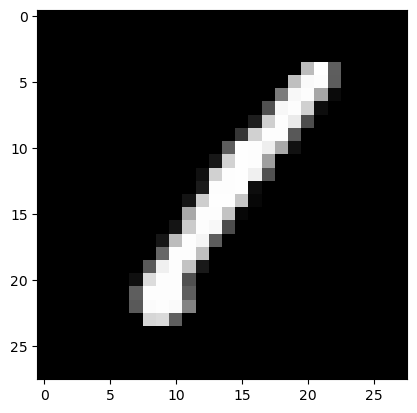

In [7]:
plot(train_X[0])

# 전처리

In [8]:
train_X = train_X / 255
test_X = test_X / 255

# Train, Valid 나누기

In [9]:
train_size = int(train_X.size(0) * 0.8)
valid_size = int(train_X.size(0) * 0.2)
print(train_size, valid_size)

33600 8400


In [10]:
# 학습할 때 마다 train/valid set을 바꾸기 위해 사용
indices = torch.randperm(train_X.size(0))
train_X = torch.index_select(train_X, dim=0, index=indices)
train_y = torch.index_select(train_y, dim=0, index=indices)

train_X, valid_X = train_X.split([train_size, valid_size], dim=0)
train_y, valid_y = train_y.split([train_size, valid_size], dim=0)

In [11]:
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape)

torch.Size([33600, 28, 28]) torch.Size([33600, 1])
torch.Size([8400, 28, 28]) torch.Size([8400, 1])
torch.Size([28000, 28, 28])


# 모델 구성하기

In [12]:
class ConvolutionBlock(nn.Module):
    
    def __init__(self, 
                 input_channels, 
                 output_channels):
        self.input_channels = input_channels
        self.output_channels = output_channels

        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, (3, 3), padding=1), 
            nn.LeakyReLU(), 
            nn.BatchNorm2d(output_channels), 
            nn.Conv2d(output_channels, output_channels, (3, 3), stride=2, padding=1), 
            nn.LeakyReLU(), 
            nn.BatchNorm2d(output_channels)
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [13]:
class ConvolutionalClassifier(nn.Module):
    
    def __init__(self, output_size):
        self.output_size = output_size
        
        super().__init__()

        self.blocks = nn.Sequential(
            ConvolutionBlock(1, 32),
            ConvolutionBlock(32, 64),
            ConvolutionBlock(64, 128),
            ConvolutionBlock(128, 256),
            ConvolutionBlock(256, 512),
        )

        self.layers = nn.Sequential(
            nn.Linear(512, 250), 
            nn.LeakyReLU(), 
            nn.BatchNorm1d(250), 
            nn.Linear(250, 100), 
            nn.LeakyReLU(), 
            nn.BatchNorm1d(100), 
            nn.Linear(100, 30), 
            nn.LeakyReLU(), 
            nn.BatchNorm1d(30), 
            nn.Linear(30, output_size), 
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        assert x.dim() > 2

        if x.dim() == 3:
            x = x.view(-1, 1, x.size(-2), x.size(-1))
            
        z = self.blocks(x)
        y = self.layers(z.squeeze())
        return y


In [14]:
model = ConvolutionalClassifier(10)
model

ConvolutionalClassifier(
  (blocks): Sequential(
    (0): ConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvolutionBlock(
      (layers): Seq

In [15]:
crit = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# GPU가 있으면 이동

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

train_X, train_y = train_X.to(device), train_y.to(device)
valid_X, valid_y = valid_X.to(device), valid_y.to(device)
test_X = test_X.to(device)

# 학습

In [17]:
n_epochs = 500
batch_size = 256
print_interval = 10

In [18]:
train_history, valid_history = [], []

In [19]:
from copy import deepcopy

best_model = None
lowest_loss = np.inf

lowest_epoch = 0
early_stop = 100

In [20]:
for i in range(n_epochs):
    model.train()

    indices = torch.randperm(train_X.size(0)).to(device)
    train_X_ = torch.index_select(train_X, dim=0, index=indices)
    train_y_ = torch.index_select(train_y, dim=0, index=indices)

    train_X_ = train_X_.split(batch_size, dim=0)
    train_y_ = train_y_.split(batch_size, dim=0)

    train_loss = 0
    valid_loss = 0

    for x, y in zip(train_X_, train_y_):
        y_pred = model(x)
        loss = crit(y_pred, y.squeeze())

        optimizer.zero_grad() # 이전 grad와 연결 끊기
        loss.backward()

        optimizer.step()
        train_loss += float(loss) # 메모리 누수 방지를 위해 중요하다고 함

    train_loss = train_loss / len(train_X_)

    model.eval() # 검증 모드로 변경
    with torch.no_grad(): # 파라미터 업데이트 안함
        valid_X_ = valid_X.split(batch_size, dim=0)
        valid_y_ = valid_y.split(batch_size, dim=0)

        for x, y in zip(valid_X_, valid_y_):
            y_pred = model(x)
            loss = crit(y_pred, y.squeeze())

            valid_loss+=float(loss)

    valid_loss = valid_loss / len(valid_X_)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())

    if (i+1) % print_interval == 0:
        print(f'epoch {i+1} / train loss: {train_loss:2e}, valid loss: {valid_loss:2e}, lowest loss: {lowest_loss:2e}')

    if early_stop > 0 and lowest_epoch + early_stop < i+1:
        print(f'early stop epoch: {i+1}')
        break

print(f'lowest validation loss from epoch {lowest_epoch+1}: {lowest_loss:2e}')
model.load_state_dict(best_model) # model에 best일 때의 파라미터를 불러와 적용

epoch 10 / train loss: 2.309446e-02, valid loss: 4.821676e-02, lowest loss: 4.821676e-02
epoch 20 / train loss: 7.736642e-03, valid loss: 5.572568e-02, lowest loss: 3.837137e-02
epoch 30 / train loss: 9.062593e-03, valid loss: 4.271690e-02, lowest loss: 3.730293e-02
epoch 40 / train loss: 5.858660e-03, valid loss: 5.208963e-02, lowest loss: 3.730293e-02
epoch 50 / train loss: 4.961355e-03, valid loss: 4.376941e-02, lowest loss: 3.654723e-02
epoch 60 / train loss: 2.644055e-03, valid loss: 4.699663e-02, lowest loss: 3.654723e-02
epoch 70 / train loss: 1.155755e-03, valid loss: 5.681080e-02, lowest loss: 3.654723e-02
epoch 80 / train loss: 1.239471e-04, valid loss: 3.798629e-02, lowest loss: 3.654723e-02
epoch 90 / train loss: 1.939977e-05, valid loss: 4.000635e-02, lowest loss: 3.654723e-02
epoch 100 / train loss: 7.209649e-03, valid loss: 4.346917e-02, lowest loss: 3.654723e-02
epoch 110 / train loss: 2.179653e-03, valid loss: 4.199747e-02, lowest loss: 3.654723e-02
epoch 120 / train l

<All keys matched successfully>

# Loss 움직임 비교

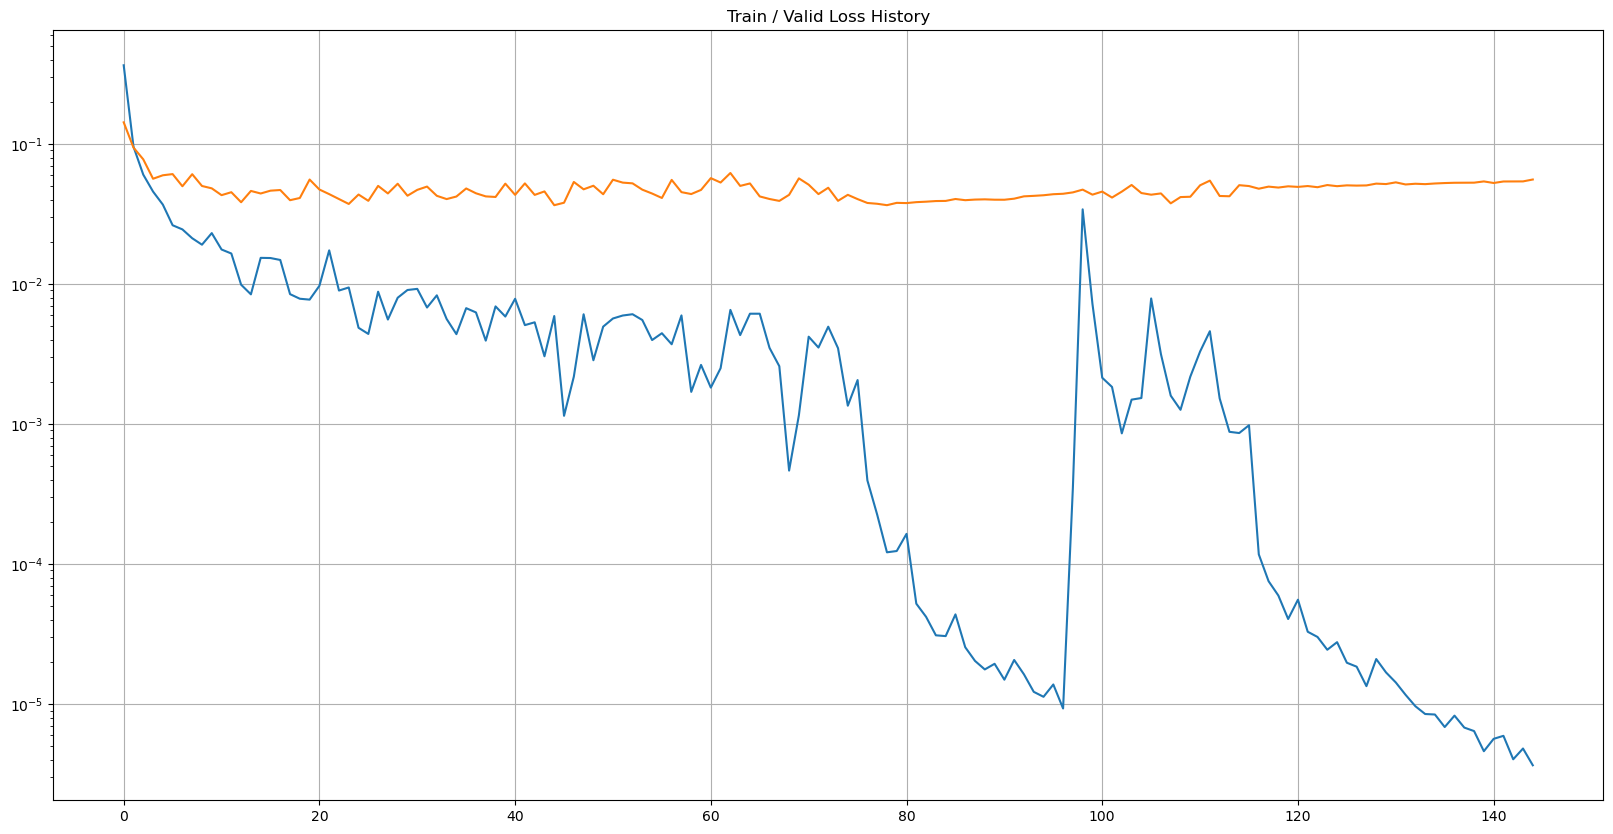

In [21]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

# Test 예측

In [22]:
test_pred = []

model.eval()
with torch.no_grad():
    test_X_ = test_X.split(batch_size, dim=0)

    for x in test_X_:
        y_pred = model(x.float())
        test_pred.append(y_pred)

test_pred = torch.cat(test_pred, dim=0)

In [23]:
pred_df = pd.DataFrame({
        "ImageId": test_df.index + 1,
        "Label": torch.argmax(test_pred, dim=-1).cpu().numpy()
    })
pred_df.to_csv('./submissions/submission.csv', index=False)